# Notebook 62: The Mixed-Stripped Spectrum

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures)
# should match the first two digits in the notebook's title
nb_id = 62

CHE stars become helium rich and acquire thick winds both due to having high luminosities, if they are massive enough ($\gtrsim100\,\mathrm{M}_\odot$); and due to mixing helium from the core out onto the surface, in all cases. The latter mechanism for helium enrichment allows stars with masses of $\lesssim100\,\mathrm{M}_\odot$, which would not ordinarily develope thick winds during the Main Sequence, to do so. Thus, through both mixing and enhanced mass loss, rotation makes it possible for stars that would not usually become Wolf-Rayet stars (outside of binary stripping; perhaps He star is the more adequate term) to do so. This might populate a range of WR star masses at metallicities for which WR stars would not be expected from the stripping channel; specifically, rotational mixing might produce relatively massive WR stars at low metallicities where none but the most massive stars would be expected to produce WR stars, but resulting in overly massive WR stars due to the lack of strong mass loss in the MS.

In any case, it is important to understand how mixing and stripping contribute to He-enrichment in the Main Sequence, and how this balance depends on initial mass and metallicity. Both mechanisms can be expected to contribute generally, so we would like to quantify the relative importance of each. For a given stellar model (in a stellar evolution logic), we define a *(rotational) mixing efficiency parameter* 

$$
\eta_\mathrm{mix}^\mathrm{m} := 1 - \frac{Y_\mathrm{s}^\mathrm{w} - Y_\mathrm{s}^\mathrm{p}}{Y_\mathrm{s}^\mathrm{m} - Y_\mathrm{s}^\mathrm{p}},
$$

where $Y_\mathrm{s}^\mathrm{m}$ is the surface He fraction of the current model, $Y_\mathrm{s}^\mathrm{p}$ that of the previous model, and $Y_\mathrm{s}^\mathrm{w}$ the fraction that would have been expected for the current model if only wind mass loss had contributed to the variation in $Y_\mathrm{s}$. $Y_\mathrm{s}^\mathrm{w}$ is defined as the value of $Y^\mathrm{p}$ at the shell containing mass $M^\mathrm{p}-\dot{M}^\mathrm{p}\times\Delta t^\mathrm{p}$ in the previous model, where the three parameters are, respectively, total mass, mass loss rate and timestep evaluated at the previous model.

Below we evaluate this parameter, and how it evolves in the Main Sequence, for some stellar models over metallicity and initial mass and period.

## Imports & Definitions

In [32]:
from pathlib import Path
from math import nan

import colorsys
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, to_rgb
from matplotlib.transforms import blended_transform_factory
from astropy.cosmology import WMAP9 as cosmo
from concurrent.futures import ProcessPoolExecutor
from scipy.integrate import simpson
import astropy.units as u


import sys
sys.path.append('..')
from src.util import (Z_SUN, CODE_ROOT, DATA_ROOT, MESA_DATA_ROOT, savefig_base, get_model_folder_base, get_model_dict)
plt.style.use('./plotstyle.mplstyle')

In [3]:
th = cosmo.age(0).value * 1e9 # yr

In [4]:
PROJECT_FOLDER = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
def savefig(*args, **kwargs): 
    savefig_base(*args, nb_id=nb_id, figure_folder=FIGURE_FOLDER, **kwargs)
      
def get_model_folder(*args, **kwargs):
    return get_model_folder_base(PROJECT_FOLDER, *args, **kwargs)

In [6]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d   

def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts 

In [26]:
def get_tau_mix(prof):
    mix_types = prof.mixing_type
    first_overshoot_i = np.where(mix_types == 2)[0][0]

    r = prof.radius[:first_overshoot_i]
    d = 10.**prof.log_D_mix[:first_overshoot_i]
    h_p = prof.pressure_scale_height[:first_overshoot_i] * u.Rsun.to(u.cm)
    dt_mix = h_p**2 / d

    mix_tscale = -simpson(x=r, y=dt_mix) * u.s.to(u.yr)

    return mix_tscale

## Analysis

### Data preparation

In [7]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_5dm4zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_5dm3zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_2dm2zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_5dm2zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_1dm1zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_2dm1zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_4dm1zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_6dm1zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_8dm1zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_1dp0zsun = load_models(project_folder)


In [8]:
all_model_dicts = {
    '5e-4': model_dicts_5dm4zsun,
    '5e-3': model_dicts_5dm3zsun,
    '2e-2': model_dicts_2dm2zsun,
    '5e-2': model_dicts_5dm2zsun,
    '1e-1': model_dicts_1dm1zsun,
    '2e-1': model_dicts_2dm1zsun,
    '4e-1': model_dicts_4dm1zsun,
    '6e-1': model_dicts_6dm1zsun,
    '8e-1': model_dicts_8dm1zsun,
    '1e+0': model_dicts_1dp0zsun
}

### A test case

We will start by computing the mixing efficiency parameter for one star over the MS. For a first test case we may peak a model that is reliably mixed: a "low-mass" star with weak He-poor winds.

In [9]:
z_div_zsun = '1e-1'
m = '20.0'
p = '0.50'

path = all_model_dicts[z_div_zsun][m][p]
h = mr.MesaData(str(path/'LOGS/history.data'))
logs = mr.MesaLogDir(str(path/'LOGS'))
model_numbers = logs.model_numbers[1:] # skip pre-ZAMS

Check that this is a CHE model. Non-CHE model do not complete the MS.

In [10]:
min(h.center_h1)

3.742863491275583e-27

We cut the data around the MS. A star only needs to be chemically homogeneous, whether through mixing or stripping, during the MS to avoid expansion.

In [11]:
tams_i = np.where(h.center_h1 <= 1e-6)[0][0]
tams_model_n = h.model_number[tams_i]
model_numbers = model_numbers[model_numbers <= tams_model_n]

In [12]:
def get_y_prev_wind(prev_prof, prev_mdelta):
    prev_y = prev_prof.he4[0]
    prev_m = prev_prof.mass[0]
    curr_m = prev_m - prev_mdelta
    curr_surf_i = np.where(prev_prof.mass <= curr_m)[0][0]
    wind_y = prev_prof.he4[curr_surf_i]
    return prev_y, wind_y

We also track age and center H1, to look at how the efficiency parameter is evolving on the MS; and the variation of the surface He4 at each timestep, to account for how much enrichment is effectively due to mixing.

In [13]:
eta_arr = np.zeros(len(model_numbers)-1)
age_arr = np.zeros(len(model_numbers)-1)
center_h1_arr = np.zeros(len(model_numbers)-1)
surface_d_he4_arr = np.zeros(len(model_numbers)-1)
prof_m_arr = np.zeros(len(model_numbers)-1)
hist_m_arr = np.zeros(len(model_numbers)-1)

prev_model_i = 0
prev_model_n = model_numbers[0]
for i, model_n in enumerate(model_numbers[1:]):
    model_i = np.where(h.model_number == model_n)[0][0]
    model_y = h.surface_he4[model_i]
    model_center_h1 = h.center_h1[model_i]
    model_d_surface_he4 = h.surface_he4[model_i] - h.surface_he4[prev_model_i]
    model_age = h.star_age[model_i]
    
    hist_m_arr[i] = h.star_mass[model_i]
        
    prev_model_i = np.where(h.model_number == prev_model_n)[0][0]
    prev_mdot = 10.**h.log_abs_mdot[prev_model_i]
    prev_dt = 10.**h.log_dt[prev_model_i]
    prev_m = h.star_mass[prev_model_i]
    prev_prof = logs.profile_data(model_number=prev_model_n)
    
    # Models are not saved every step
    # To get the total mass loss, we sum over history rows
    mdelta = 0
    for j in range(prev_model_i, model_i):
        mdelta += 10.**h.log_abs_mdot[j] * 10.**h.log_dt[j]
        
    prof_m_arr[i] = prev_m - mdelta
    prev_y, wind_y = get_y_prev_wind(prev_prof, mdelta)
    
    eta = 1 - (wind_y - prev_y) / (model_y - prev_y)
    eta_arr[i] = eta
    center_h1_arr[i] = model_center_h1
    surface_d_he4_arr[i] = model_d_surface_he4
    age_arr[i] = model_age
    prev_model_n = model_n

There are small numerical fluctuations of the mass computed with the mass loss rate relative to the reported mass, but otherwise they are consistent.

*(note: are they really? I'm not sure 1e-4 is insignificant)*

Text(0.5, 0, 'Model')

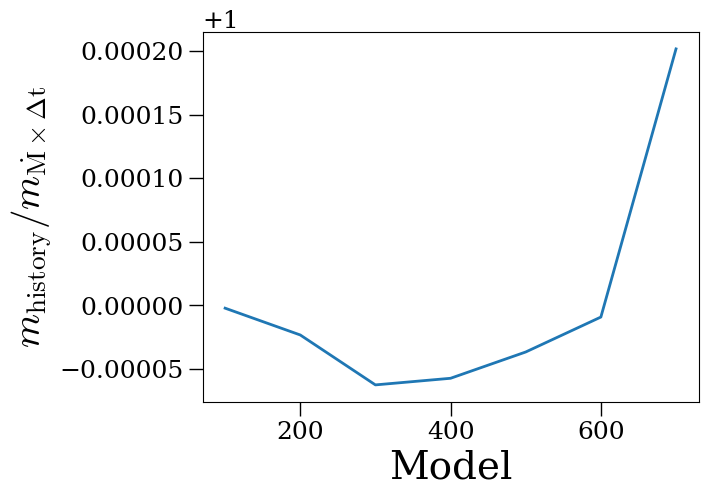

In [14]:
plt.plot(model_numbers[:-1], hist_m_arr/prof_m_arr)
plt.ylabel('$m_\mathrm{history}/m_\mathrm{\\dot{M}\\times\Delta t}$')
plt.xlabel('Model')

We can now look at how the efficiency parameter evolved in the MS.

<Axes: title={'center': '1e-1$\\mathrm{Z}_\\odot$ $20.0\\mathrm{M}_\\odot$ $0.50\\,\\mathrm{d}$'}, xlabel='Center H1', ylabel='$\\eta_\\mathrm{m}$'>

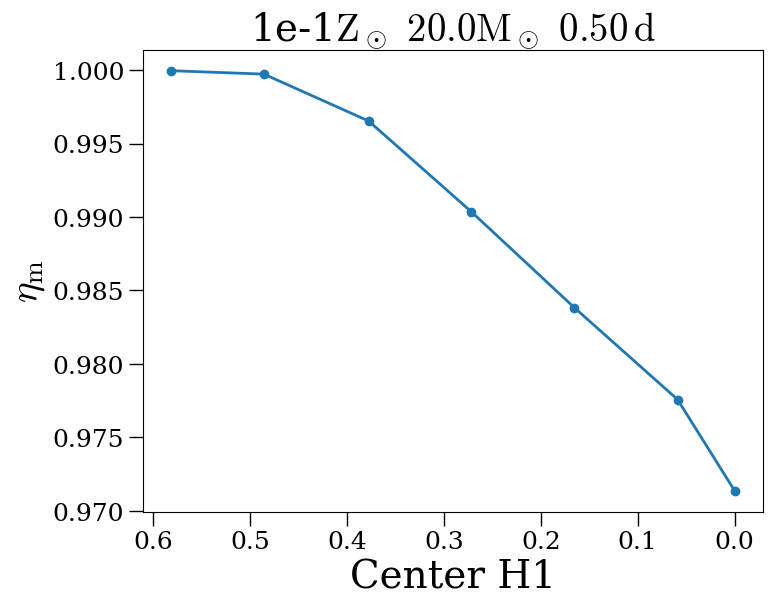

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(center_h1_arr, eta_arr, marker='o')
ax.invert_xaxis()

ax.set_xlabel(r'Center H1')
ax.set_ylabel(r'$\eta_\mathrm{m}$')

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$')
ax

As expected, this is a strongly mixed star, although even in this case stripping goes as far as contributing to $\sim3\%$ of the He-enrichment by the end of the MS. This is to be expected: every CHE star acquires thick winds in the MS, at the very least because we allow them to transition to thick He-rich winds as $Y-\mathrm{s}$ increases. Thus the contribution of wind mass loss to He enrichment increases towards the end of the MS, and $\eta_\mathrm{m}$ decreases.

A $20\,\mathrm{M}_\odot$ star presents an extreme and very finely-tuned case (in the sense that the CHE window is very narrow), however. We may also look at the picture for a $80\,\mathrm{M}_\odot$ star that we know to be a potential $35\,\mathrm{M}_\odot$ BH progenitor, at $0.1\mathrm{Z}_\odot$.

In [132]:
z_div_zsun = '1e-1'
m = '80.0'
p = '0.80'

path = all_model_dicts[z_div_zsun][m][p]
h = mr.MesaData(str(path/'LOGS/history.data'))
logs = mr.MesaLogDir(str(path/'LOGS'))
model_numbers = logs.model_numbers # skip pre-ZAMS

In [133]:
min(h.center_h1)

0.0

In [134]:
tams_i = np.where(h.center_h1 <= 1e-6)[0][0]
tams_model_n = h.model_number[tams_i]
model_numbers = model_numbers[model_numbers <= tams_model_n]

In [135]:
model_numbers

array([   1,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600])

In [136]:
eta_arr = np.zeros(len(model_numbers)-1)
age_arr = np.zeros(len(model_numbers)-1)
center_h1_arr = np.zeros(len(model_numbers)-1)
surface_d_he4_arr = np.zeros(len(model_numbers)-1)
omega_div_omega_crit_arr = np.zeros(len(model_numbers)-1)
tau_mix_arr = np.zeros(len(model_numbers)-1)
surface_n14_arr = np.zeros(len(model_numbers)-1)
prof_m_arr = np.zeros(len(model_numbers)-1)
hist_m_arr = np.zeros(len(model_numbers)-1)

prev_model_n = model_numbers[0]
for i, model_n in enumerate(model_numbers[1:]):
    model_i = np.where(h.model_number == model_n)[0][0]
    model_y = h.surface_he4[model_i]
    model_center_h1 = h.center_h1[model_i]
    model_age = h.star_age[model_i]
    model_omega_div_omega_crit = h.surf_avg_omega_div_omega_crit[model_i]
    model_surface_n14 = h.surface_n14[model_i]
    
    hist_m_arr[i] = h.star_mass[model_i]
        
    prev_model_i = np.where(h.model_number == prev_model_n)[0][0]
    prev_mdot = 10.**h.log_abs_mdot[prev_model_i]
    prev_dt = 10.**h.log_dt[prev_model_i]
    prev_m = h.star_mass[prev_model_i]
    prev_prof = logs.profile_data(model_number=prev_model_n)
    model_d_surface_he4 = h.surface_he4[model_i] - h.surface_he4[prev_model_i]
    print(model_n, h.surface_he4[model_i], h.surface_he4[prev_model_i])
    
    # Models are not saved every step
    # To get the total mass loss, we sum over history rows
    mdelta = 0
    for j in range(prev_model_i, model_i):
        mdelta += 10.**h.log_abs_mdot[j] * 10.**h.log_dt[j]
        
    prof_m_arr[i] = prev_m - mdelta
    prev_y, wind_y = get_y_prev_wind(prev_prof, mdelta)
    
    curr_prof = logs.profile_data(model_number=model_n)
    model_tau_mix = get_tau_mix(curr_prof)
    
    eta = 1 - (wind_y - prev_y) / (model_y - prev_y)
    eta_arr[i] = eta
    center_h1_arr[i] = model_center_h1
    surface_d_he4_arr[i] = model_d_surface_he4
    age_arr[i] = model_age
    omega_div_omega_crit_arr[i] = model_omega_div_omega_crit
    surface_n14_arr[i] = model_surface_n14
    tau_mix_arr[i] = model_tau_mix
    
    prev_model_n = model_n

100 0.2883196290194989 0.28522027726685184
200 0.3794930990160702 0.2883196290194989
300 0.4704292125663882 0.3794930990160702
400 0.5212307474373202 0.4704292125663882
500 0.5603226543247608 0.5212307474373202
600 0.5933787895379883 0.5603226543247608
700 0.6221940732658909 0.5933787895379883
800 0.6474178168852263 0.6221940732658909
900 0.6680062478476886 0.6474178168852263
1000 0.6840713148185608 0.6680062478476886
1100 0.7004016609456162 0.6840713148185608
1200 0.7253951148606927 0.7004016609456162
1300 0.7591948383377474 0.7253951148606927
1400 0.7959021742959225 0.7591948383377474
1500 0.8325447191041558 0.7959021742959225
1600 0.871276865006406 0.8325447191041558


Text(0.5, 0, 'Model')

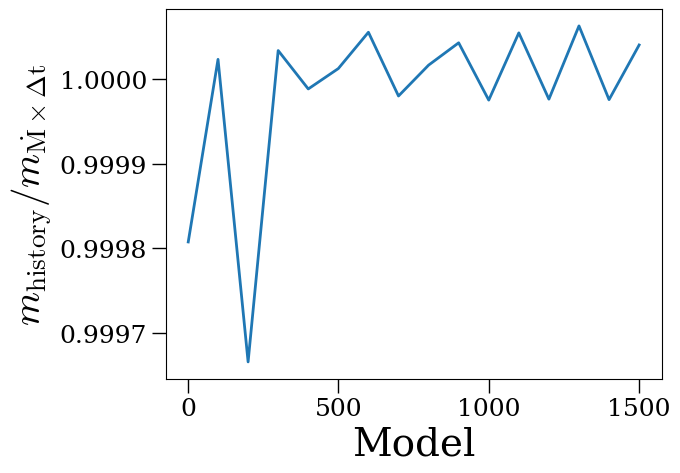

In [137]:
plt.plot(model_numbers[:-1], hist_m_arr/prof_m_arr)
plt.ylabel('$m_\mathrm{history}/m_\mathrm{\\dot{M}\\times\Delta t}$')
plt.xlabel('Model')

Text(0.5, 1.0, '1e-1$\\mathrm{Z}_\\odot$ $80.0\\mathrm{M}_\\odot$ $0.80\\,\\mathrm{d}$')

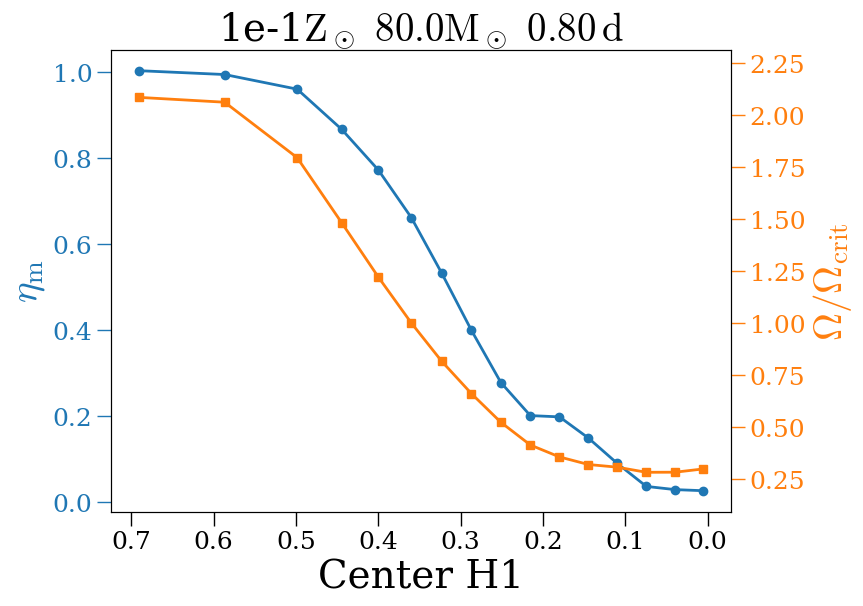

In [138]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(center_h1_arr, eta_arr, marker='o')
ax.plot(center_h1_arr, omega_div_omega_crit_arr, marker='s')
ax.invert_xaxis()

ax.set_xlabel(r'Center H1')
ax.set_ylabel(r'$\eta_\mathrm{m}$', color='C0')
ax.tick_params(axis='y', color='C0', labelcolor='C0')

ax2 = ax.twinx()
ax2.set_ylim(ax.set_ylim())
ax2.set_ylabel(r'$\Omega/\Omega_\mathrm{crit}$', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.set_ylim(miny2, maxy2)

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$')


We can also see the decreasing efficiency of mixing by tracking the evolution of the mixing timescale. It increases by two orders of magnitude during the MS.

/tmp/ipykernel_1132565/3637841958.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{2*tick-1:.1f}' for tick in ax2.get_yticks()])


Text(0.5, 1.0, '1e-1$\\mathrm{Z}_\\odot$ $80.0\\mathrm{M}_\\odot$ $0.80\\,\\mathrm{d}$')

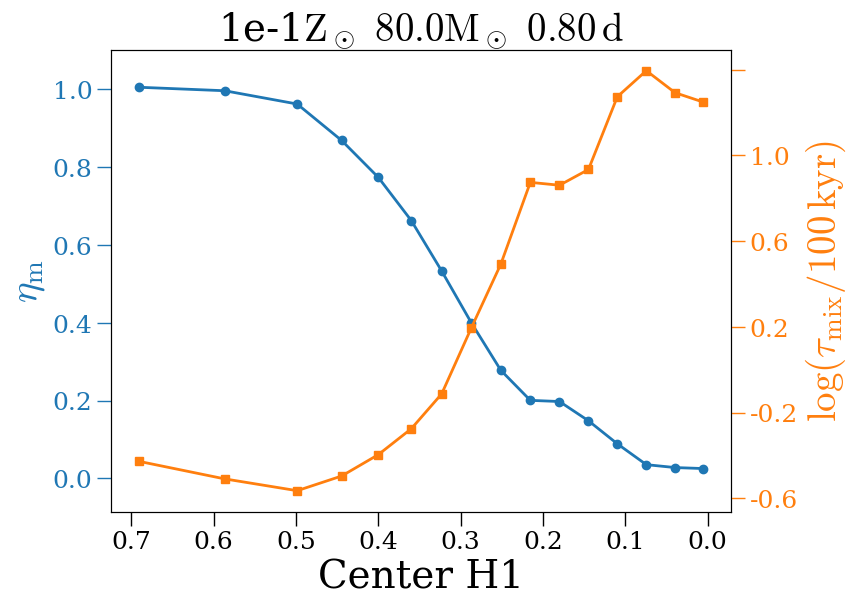

In [139]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(center_h1_arr, eta_arr, marker='o')
ax.plot(center_h1_arr, (np.log10(tau_mix_arr/1e6)+1)/2, marker='s')
ax.invert_xaxis()

ax.set_xlabel(r'Center H1')
ax.set_ylabel(r'$\eta_\mathrm{m}$', color='C0')
ax.tick_params(axis='y', color='C0', labelcolor='C0')

ax2 = ax.twinx()
miny2 = (np.log10(tau_mix_arr.min()/1e6)+1)/2
maxy2 = (np.log10(tau_mix_arr.max()/1e6)+1)/2
ax2.set_yticklabels([f'{2*tick-1:.1f}' for tick in ax2.get_yticks()])
ax2.set_ylabel(r'$\log(\tau_\mathrm{mix}/100\,\mathrm{kyr})$', color='C1')
ax2.set_ylim(miny2, maxy2)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$')


A-ha! We get a much less clear definition of a CHE star now, as $\eta_\mathrm{m}$ drops considerably still in the middle of the MS, and is effectively 0 by its end. Here we not only see the effect of enhanced He-rich winds on the surface He, but also on spin-down due to stronger winds suppressing efficient rotational mixing.

A case like this begs the question: how do we define the degree to which a given star is mixed or stripped, accounting for the *whole* MS? This case, for example, seems to be near the middle of the "mixed-stripped spectrum" from the plot above. We ought to account, however, for how much time is effectively spent with enhanced winds/suppressed mixing.

Text(0.5, 1.0, '1e-1$\\mathrm{Z}_\\odot$ $80.0\\mathrm{M}_\\odot$ $0.80\\,\\mathrm{d}$')

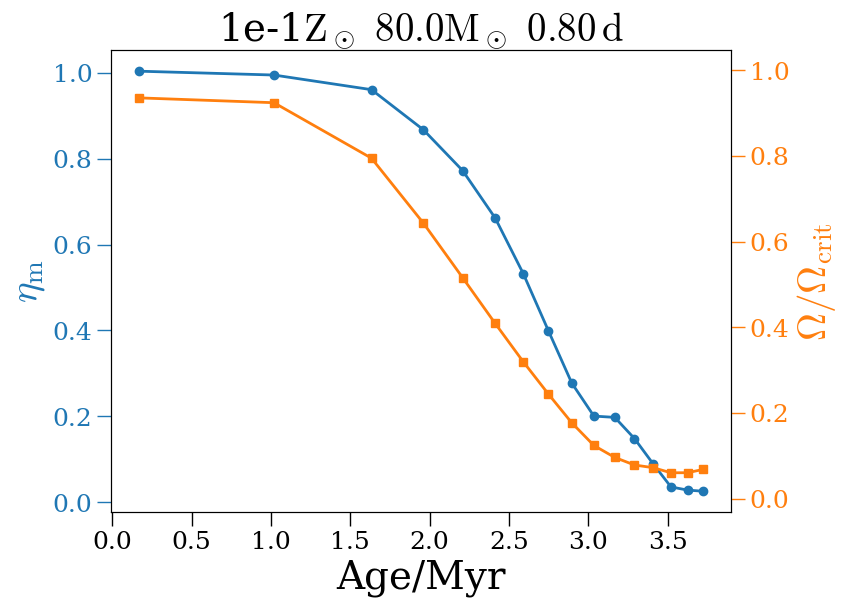

In [119]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(age_arr/1e6, eta_arr, marker='o')
ax.plot(age_arr/1e6, omega_div_omega_crit_arr, marker='s')

ax.set_xlabel(r'Age/Myr')
ax.set_ylabel(r'$\eta_\mathrm{m}$', color='C0')
ax.tick_params(axis='y', color='C0', labelcolor='C0')

ax2 = ax.twinx()
ax2.set_ylim(ax.set_ylim())
ax2.set_ylabel(r'$\Omega/\Omega_\mathrm{crit}$', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.set_ylim(miny2, maxy2)

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$')


The stripping-dominated region is somewhat shrunk, but not by much. A more accurate picture might be given by treating $\eta_\mathrm{m}$ as the "fraction of He-enrichment due to mixing". In that case, we can track how much of the variation in $Y_\mathrm{s}$ during each interval was due to mixing and how much was due to stripping ($\delta Y_\mathrm{s}$ per interval). Summing over all intervals allows us to obtain the total enrichment due to each mechanism ($\Delta Y_\mathrm{s}$). We then tentatively define a *mixing-stripping score* $\mathrm{H}_\mathrm{ms}$,

$$
\mathrm{H}_\mathrm{ms} = 2\frac{(\Delta Y_\mathrm{s})_\mathrm{mix}}{\Delta Y_\mathrm{s}} - 1,
$$

such that a fully mixed star has score $\mathrm{H}_\mathrm{ms}=+1$, a fully stripped star has score $\mathrm{H}_\mathrm{ms}=-1$, and a star with He-enrichment due in equal parts to mixing and stripping has score $\mathrm{H}_\mathrm{ms}=0$.

Text(0.5, 1.0, '1e-1$\\mathrm{Z}_\\odot$ $80.0\\mathrm{M}_\\odot$ $0.80\\,\\mathrm{d}$\n$\\mathrm{H}_\\mathrm{ms}=0.109$')

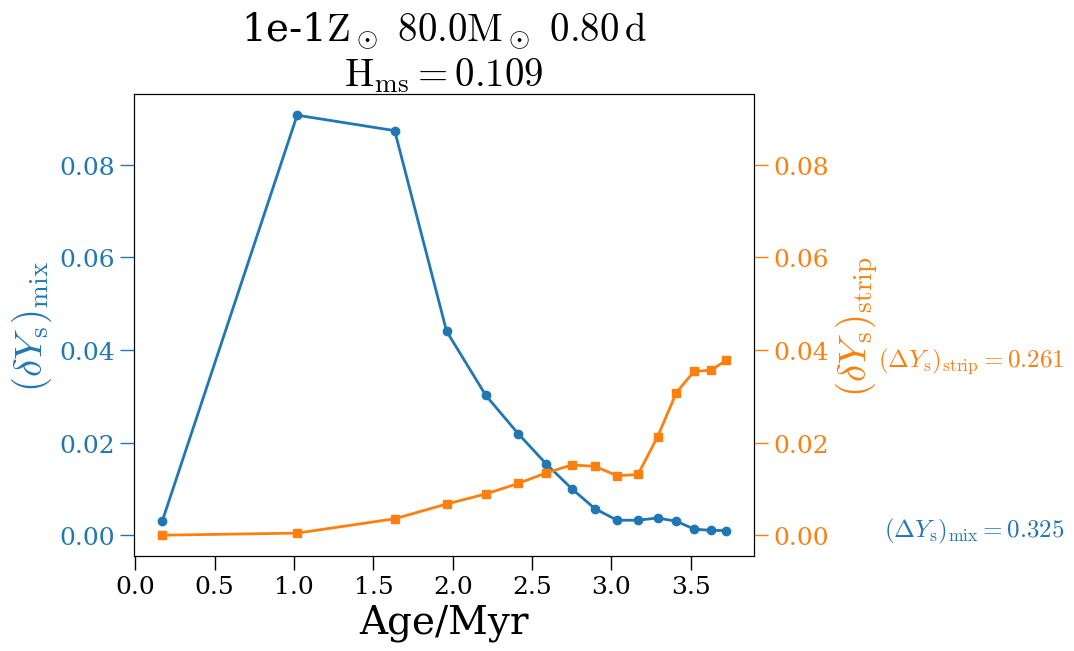

In [121]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(age_arr/1e6, eta_arr*surface_d_he4_arr, marker='o')
ax.plot(age_arr/1e6, (1-eta_arr)*surface_d_he4_arr, marker='s')

total_mix_d = sum(eta_arr*surface_d_he4_arr)
total_strip_d = sum((1-eta_arr)*surface_d_he4_arr)

ax.text(
    1.5,
    (eta_arr*surface_d_he4_arr)[-1],
    f'$(\Delta Y_\mathrm{{s}})_\mathrm{{mix}}={total_mix_d:.3f}$',
    fontsize=18,
    va='center',
    ha='right',
    color='C0',
    transform=blended_transform_factory(ax.transAxes, ax.transData)
)

ax.text(
    1.5,
    ((1-eta_arr)*surface_d_he4_arr)[-1],
    f'$(\Delta Y_\mathrm{{s}})_\mathrm{{strip}}={total_strip_d:.3f}$',
    fontsize=18,
    va='center',
    ha='right',
    color='C1',
    transform=blended_transform_factory(ax.transAxes, ax.transData)
)

ax.set_xlabel(r'Age/Myr')
ax.set_ylabel(r'$(\delta Y_\mathrm{s})_\mathrm{mix}$', color='C0')
ax.tick_params(axis='y', color='C0', labelcolor='C0')


ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$(\delta Y_\mathrm{s})_\mathrm{strip}$', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')

mixing_score = 2 * (total_mix_d/(total_mix_d+total_strip_d) - 0.5)

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$\n$\mathrm{{H}}_\\mathrm{{ms}}={mixing_score:.3f}$')


We see now that our $35\,\mathrm{M}_\odot$ BH progenitor is in this metric classified as only slightly more mixed than stripped. Note, however, that this does not account for the fact that, in the absence of mixing, this star would likely not have developed thick winds in the MS, and thus have been much more weakly stripped. The actual importance of mixing in its evolution is thus higher than what the score implies.

We can attempt an alternate definition that accounts for that. Presumably, any star that acquires thick winds in the MS will "look" like a CHE star: either it is a VMS with thick winds regardless of mixing, or it has developed thick winds because it has already been enriched through rotation and will presumably avoid a supergiant stage. Say there is a threshold surface He4 $Y_\mathrm{th}$ which, once reached, guarantees the star will be chemically homogeneously evolving. Our mixing-stripping score might then be more accurately computed by only accounting for enrichment that happened before that point. 

In our current models, the transition from thin He-poor winds to thick He-rich winds happens linearly between $Y_\mathrm{th}=0.4$ and $0.7$. Let us take a conservative approach and say that any star that reaches $Y_\mathrm{th}=0.7$ will acquire enough of a wind enhancement that, even if mixing is not efficient enough to keep it CHE (though it likely is at such high surface He4), stripping will "finish the job". We thus limit our evaluation of mixing-stripping accordingly, for the same star.

In [122]:
z_div_zsun = '1e-1'
m = '80.0'
p = '0.80'
y_th = 0.7

path = all_model_dicts[z_div_zsun][m][p]
h = mr.MesaData(str(path/'LOGS/history.data'))
logs = mr.MesaLogDir(str(path/'LOGS'))
model_numbers = logs.model_numbers # skip pre-ZAMS

stop_i = np.where(h.surface_he4 >= y_th)[0][0]
stop_model_n = h.model_number[stop_i]
model_numbers = model_numbers[model_numbers <= stop_model_n]
print(model_numbers)

[   1  100  200  300  400  500  600  700  800  900 1000]


In [124]:
eta_arr = np.zeros(len(model_numbers)-1)
age_arr = np.zeros(len(model_numbers)-1)
center_h1_arr = np.zeros(len(model_numbers)-1)
surface_d_he4_arr = np.zeros(len(model_numbers)-1)
omega_div_omega_crit_arr = np.zeros(len(model_numbers)-1)
tau_mix_arr = np.zeros(len(model_numbers)-1)
surface_n14_arr = np.zeros(len(model_numbers)-1)
prof_m_arr = np.zeros(len(model_numbers)-1)
hist_m_arr = np.zeros(len(model_numbers)-1)

prev_model_n = model_numbers[0]
for i, model_n in enumerate(model_numbers[1:]):
    model_i = np.where(h.model_number == model_n)[0][0]
    model_y = h.surface_he4[model_i]
    model_center_h1 = h.center_h1[model_i]
    model_age = h.star_age[model_i]
    model_omega_div_omega_crit = h.surf_avg_omega_div_omega_crit[model_i]
    model_surface_n14 = h.surface_n14[model_i]
    
    hist_m_arr[i] = h.star_mass[model_i]
        
    prev_model_i = np.where(h.model_number == prev_model_n)[0][0]
    prev_mdot = 10.**h.log_abs_mdot[prev_model_i]
    prev_dt = 10.**h.log_dt[prev_model_i]
    prev_m = h.star_mass[prev_model_i]
    prev_prof = logs.profile_data(model_number=prev_model_n)
    model_d_surface_he4 = h.surface_he4[model_i] - h.surface_he4[prev_model_i]
    print(model_n, h.surface_he4[model_i], h.surface_he4[prev_model_i])
    
    # Models are not saved every step
    # To get the total mass loss, we sum over history rows
    mdelta = 0
    for j in range(prev_model_i, model_i):
        mdelta += 10.**h.log_abs_mdot[j] * 10.**h.log_dt[j]
        
    prof_m_arr[i] = prev_m - mdelta
    prev_y, wind_y = get_y_prev_wind(prev_prof, mdelta)
    
    curr_prof = logs.profile_data(model_number=model_n)
    model_tau_mix = get_tau_mix(curr_prof)
    
    eta = 1 - (wind_y - prev_y) / (model_y - prev_y)
    eta_arr[i] = eta
    center_h1_arr[i] = model_center_h1
    surface_d_he4_arr[i] = model_d_surface_he4
    age_arr[i] = model_age
    omega_div_omega_crit_arr[i] = model_omega_div_omega_crit
    surface_n14_arr[i] = model_surface_n14
    tau_mix_arr[i] = model_tau_mix
    
    prev_model_n = model_n

100 0.2883196290194989 0.28522027726685184
200 0.3794930990160702 0.2883196290194989
300 0.4704292125663882 0.3794930990160702
400 0.5212307474373202 0.4704292125663882
500 0.5603226543247608 0.5212307474373202
600 0.5933787895379883 0.5603226543247608
700 0.6221940732658909 0.5933787895379883
800 0.6474178168852263 0.6221940732658909
900 0.6680062478476886 0.6474178168852263
1000 0.6840713148185608 0.6680062478476886


Text(0.5, 1.0, '1e-1$\\mathrm{Z}_\\odot$ $80.0\\mathrm{M}_\\odot$ $0.80\\,\\mathrm{d}$\n$\\mathrm{H}_\\mathrm{ms}=0.563$')

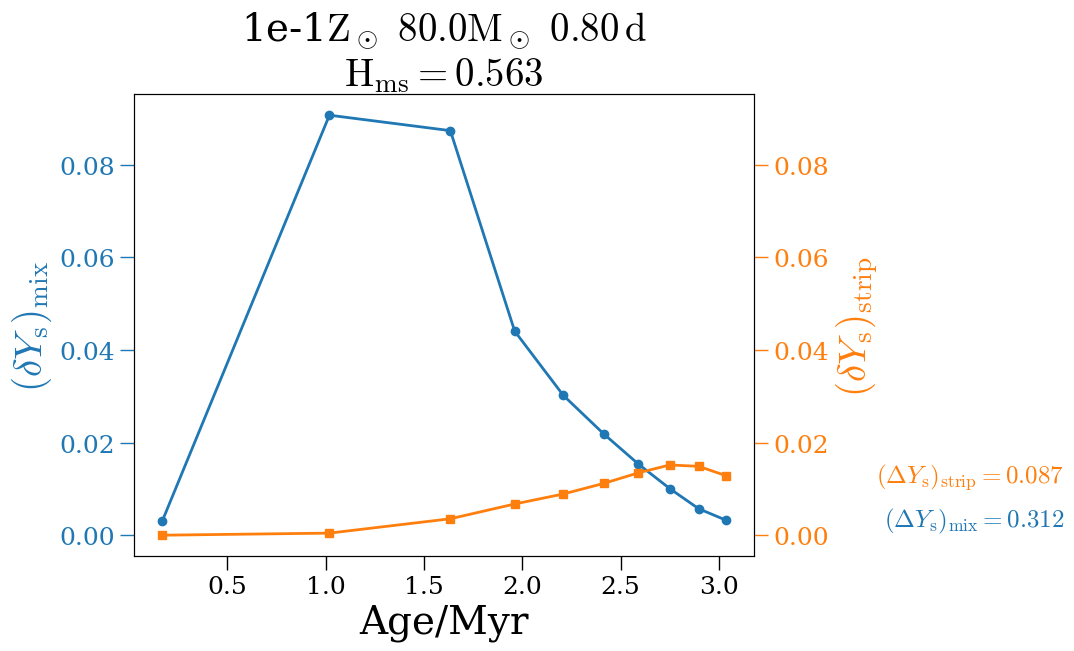

In [125]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(age_arr/1e6, eta_arr*surface_d_he4_arr, marker='o')
ax.plot(age_arr/1e6, (1-eta_arr)*surface_d_he4_arr, marker='s')

total_mix_d = sum(eta_arr*surface_d_he4_arr)
total_strip_d = sum((1-eta_arr)*surface_d_he4_arr)

ax.text(
    1.5,
    (eta_arr*surface_d_he4_arr)[-1],
    f'$(\Delta Y_\mathrm{{s}})_\mathrm{{mix}}={total_mix_d:.3f}$',
    fontsize=18,
    va='center',
    ha='right',
    color='C0',
    transform=blended_transform_factory(ax.transAxes, ax.transData)
)

ax.text(
    1.5,
    ((1-eta_arr)*surface_d_he4_arr)[-1],
    f'$(\Delta Y_\mathrm{{s}})_\mathrm{{strip}}={total_strip_d:.3f}$',
    fontsize=18,
    va='center',
    ha='right',
    color='C1',
    transform=blended_transform_factory(ax.transAxes, ax.transData)
)

ax.set_xlabel(r'Age/Myr')
ax.set_ylabel(r'$(\delta Y_\mathrm{s})_\mathrm{mix}$', color='C0')
ax.tick_params(axis='y', color='C0', labelcolor='C0')


ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$(\delta Y_\mathrm{s})_\mathrm{strip}$', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')

mixing_score = 2 * (total_mix_d/(total_mix_d+total_strip_d) - 0.5)

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$\n$\mathrm{{H}}_\\mathrm{{ms}}={mixing_score:.3f}$')

A conservative limitation on the region from which the score is evaluated already puts this star well within the mixing side of the mixing-stripping spectrum. It is possible that a lower $Y_\mathrm{th}$ is more adequate, since there should be a few cases were partially enhanced winds are enough to keep the star CHE. We can re-evaluate this once we have computed the score for the full grid.

Before moving on, we should look at the opposite end of the spectrum --- a very massive, high-metallicity star --- and see if our scoring accurately reflects the dominant role of stripping.

In [140]:
z_div_zsun = '1e+0'
m = '300.0'
p = '4.00'
y_th = 0.7

path = all_model_dicts[z_div_zsun][m][p]
h = mr.MesaData(str(path/'LOGS/history.data'))
logs = mr.MesaLogDir(str(path/'LOGS'))
model_numbers = logs.model_numbers # skip pre-ZAMS

stop_i = np.where(h.surface_he4 >= y_th)[0][0]
stop_model_n = h.model_number[stop_i]
model_numbers = model_numbers[model_numbers <= stop_model_n]
print(model_numbers)

[   1  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700
 2800 2900]


In [141]:
min(h.center_h1)

7.985147848745989e-28

In [142]:
eta_arr = np.zeros(len(model_numbers)-1)
age_arr = np.zeros(len(model_numbers)-1)
center_h1_arr = np.zeros(len(model_numbers)-1)
surface_d_he4_arr = np.zeros(len(model_numbers)-1)
omega_div_omega_crit_arr = np.zeros(len(model_numbers)-1)
tau_mix_arr = np.zeros(len(model_numbers)-1)
surface_n14_arr = np.zeros(len(model_numbers)-1)
prof_m_arr = np.zeros(len(model_numbers)-1)
hist_m_arr = np.zeros(len(model_numbers)-1)

prev_model_n = model_numbers[0]
for i, model_n in enumerate(model_numbers[1:]):
    model_i = np.where(h.model_number == model_n)[0][0]
    model_y = h.surface_he4[model_i]
    model_center_h1 = h.center_h1[model_i]
    model_age = h.star_age[model_i]
    model_omega_div_omega_crit = h.surf_avg_omega_div_omega_crit[model_i]
    model_surface_n14 = h.surface_n14[model_i]
    
    hist_m_arr[i] = h.star_mass[model_i]
        
    prev_model_i = np.where(h.model_number == prev_model_n)[0][0]
    prev_mdot = 10.**h.log_abs_mdot[prev_model_i]
    prev_dt = 10.**h.log_dt[prev_model_i]
    prev_m = h.star_mass[prev_model_i]
    prev_prof = logs.profile_data(model_number=prev_model_n)
    model_d_surface_he4 = h.surface_he4[model_i] - h.surface_he4[prev_model_i]
    print(model_n, h.surface_he4[model_i], h.surface_he4[prev_model_i])
    
    # Models are not saved every step
    # To get the total mass loss, we sum over history rows
    mdelta = 0
    for j in range(prev_model_i, model_i):
        mdelta += 10.**h.log_abs_mdot[j] * 10.**h.log_dt[j]
        
    prof_m_arr[i] = prev_m - mdelta
    prev_y, wind_y = get_y_prev_wind(prev_prof, mdelta)
    
    curr_prof = logs.profile_data(model_number=model_n)
    model_tau_mix = get_tau_mix(curr_prof)
    
    eta = 1 - (wind_y - prev_y) / (model_y - prev_y)
    eta_arr[i] = eta
    center_h1_arr[i] = model_center_h1
    surface_d_he4_arr[i] = model_d_surface_he4
    age_arr[i] = model_age
    omega_div_omega_crit_arr[i] = model_omega_div_omega_crit
    surface_n14_arr[i] = model_surface_n14
    tau_mix_arr[i] = model_tau_mix
    
    prev_model_n = model_n

100 0.28094212644186883 0.28094032380260936
200 0.2940539096416985 0.28094212644186883
300 0.31482758711450937 0.2940539096416985
400 0.33260379554658365 0.31482758711450937
500 0.3515411233233555 0.33260379554658365
600 0.37229551475246125 0.3515411233233555
700 0.39431647975231504 0.37229551475246125
800 0.4170658733210821 0.39431647975231504
900 0.4374390599138391 0.4170658733210821
1000 0.4538497426667921 0.4374390599138391
1100 0.4677815449848201 0.4538497426667921
1200 0.4803786146111151 0.4677815449848201
1300 0.49314809171897717 0.4803786146111151
1400 0.505639927579378 0.49314809171897717
1500 0.5176038211159356 0.505639927579378
1600 0.5291291306068393 0.5176038211159356
1700 0.5403300155627601 0.5291291306068393
1800 0.5514729704264762 0.5403300155627601
1900 0.5624897331984353 0.5514729704264762
2000 0.5735881068865636 0.5624897331984353
2100 0.5848530930982893 0.5735881068865636
2200 0.5961710074298717 0.5848530930982893
2300 0.6078651179476464 0.5961710074298717
2400 0.61

Text(0.5, 0, 'Model')

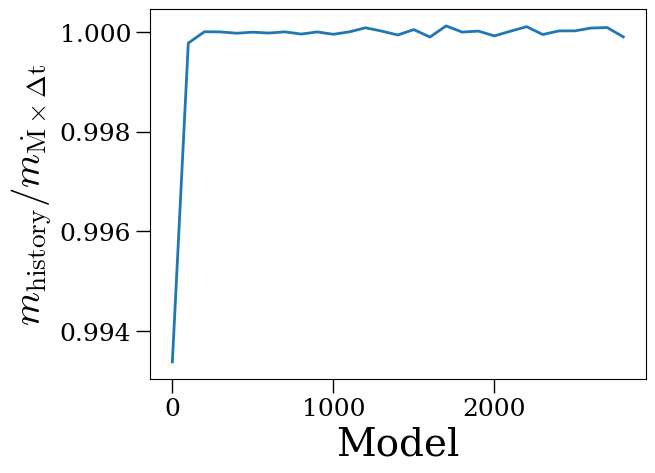

In [143]:
plt.plot(model_numbers[:-1], hist_m_arr/prof_m_arr)
plt.ylabel('$m_\mathrm{history}/m_\mathrm{\\dot{M}\\times\Delta t}$')
plt.xlabel('Model')

Something strange happens: the mixing efficiency is above 1 for the first model. This is probably related to the mass loss rate being set to 0 in the pre-ZAMS phase --- will have to check.

Text(0.5, 1.0, '1e+0$\\mathrm{Z}_\\odot$ $300.0\\mathrm{M}_\\odot$ $4.00\\,\\mathrm{d}$')

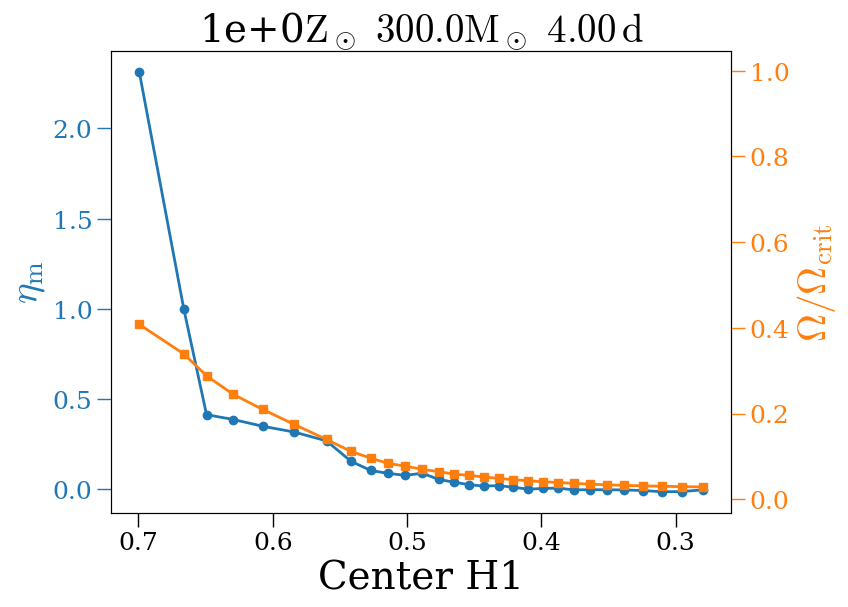

In [144]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(center_h1_arr, eta_arr, marker='o')
ax.plot(center_h1_arr, omega_div_omega_crit_arr, marker='s')
ax.invert_xaxis()

ax.set_xlabel(r'Center H1')
ax.set_ylabel(r'$\eta_\mathrm{m}$', color='C0')
ax.tick_params(axis='y', color='C0', labelcolor='C0')

ax2 = ax.twinx()
ax2.set_ylim(ax.set_ylim())
ax2.set_ylabel(r'$\Omega/\Omega_\mathrm{crit}$', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.set_ylim(miny2, maxy2)

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$')


/tmp/ipykernel_1132565/3160830461.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{2*tick-1:.1f}' for tick in ax2.get_yticks()])


Text(0.5, 1.0, '1e+0$\\mathrm{Z}_\\odot$ $300.0\\mathrm{M}_\\odot$ $4.00\\,\\mathrm{d}$')

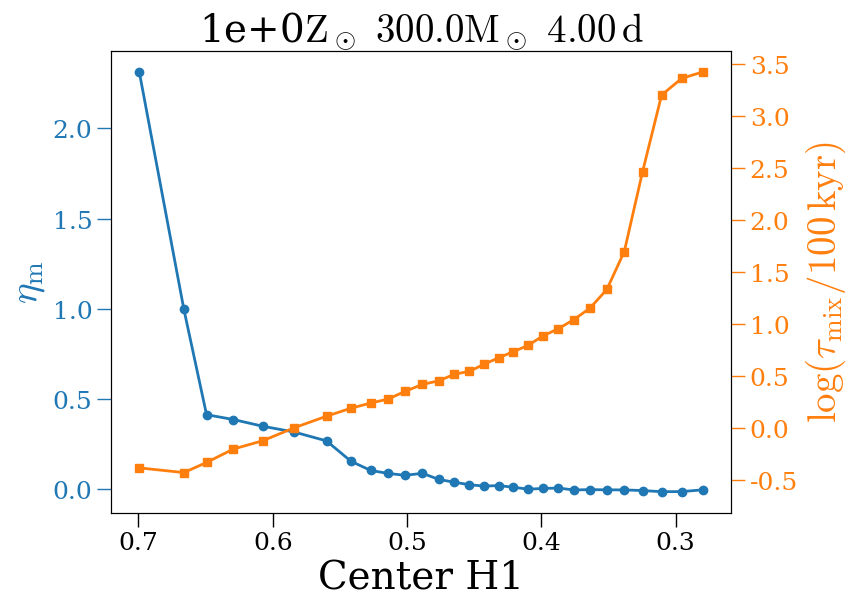

In [147]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(center_h1_arr, eta_arr, marker='o')
ax.plot(center_h1_arr, (np.log10(tau_mix_arr/1e6)+1)/2, marker='s')
ax.invert_xaxis()

ax.set_xlabel(r'Center H1')
ax.set_ylabel(r'$\eta_\mathrm{m}$', color='C0')
ax.tick_params(axis='y', color='C0', labelcolor='C0')

ax2 = ax.twinx()
miny2 = (np.log10(tau_mix_arr.min()/1e6)+1)/2
maxy2 = (np.log10(tau_mix_arr.max()/1e6)+1)/2
ax2.set_ylim(miny2, maxy2)
ax2.set_yticklabels([f'{2*tick-1:.1f}' for tick in ax2.get_yticks()])
ax2.set_ylabel(r'$\log(\tau_\mathrm{mix}/100\,\mathrm{kyr})$', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$')


With VMS winds, the increase in the mixing scale is by three orders magnitude by the time $Y_\mathrm{s}=0.7$ is reached!

Text(0.5, 1.0, '1e+0$\\mathrm{Z}_\\odot$ $300.0\\mathrm{M}_\\odot$ $4.00\\,\\mathrm{d}$\n$\\mathrm{H}_\\mathrm{ms}=-0.713$')

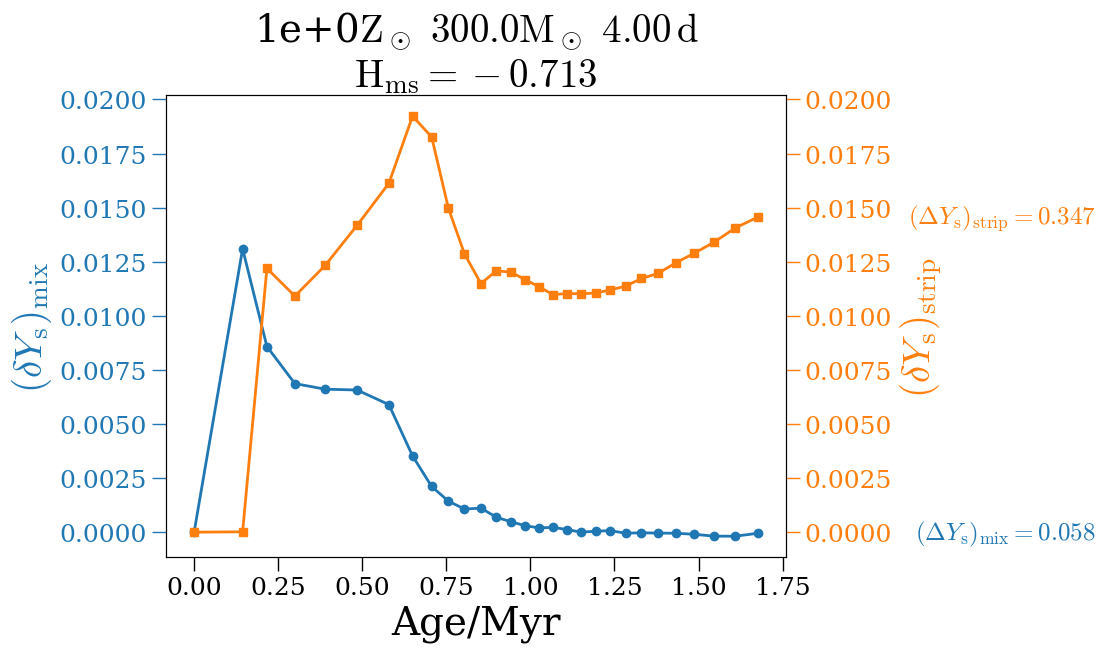

In [145]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(age_arr/1e6, eta_arr*surface_d_he4_arr, marker='o')
ax.plot(age_arr/1e6, (1-eta_arr)*surface_d_he4_arr, marker='s')

total_mix_d = sum(eta_arr*surface_d_he4_arr)
total_strip_d = sum((1-eta_arr)*surface_d_he4_arr)

ax.text(
    1.5,
    (eta_arr*surface_d_he4_arr)[-1],
    f'$(\Delta Y_\mathrm{{s}})_\mathrm{{mix}}={total_mix_d:.3f}$',
    fontsize=18,
    va='center',
    ha='right',
    color='C0',
    transform=blended_transform_factory(ax.transAxes, ax.transData)
)

ax.text(
    1.5,
    ((1-eta_arr)*surface_d_he4_arr)[-1],
    f'$(\Delta Y_\mathrm{{s}})_\mathrm{{strip}}={total_strip_d:.3f}$',
    fontsize=18,
    va='center',
    ha='right',
    color='C1',
    transform=blended_transform_factory(ax.transAxes, ax.transData)
)

ax.set_xlabel(r'Age/Myr')
ax.set_ylabel(r'$(\delta Y_\mathrm{s})_\mathrm{mix}$', color='C0')
ax.tick_params(axis='y', color='C0', labelcolor='C0')


ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$(\delta Y_\mathrm{s})_\mathrm{strip}$', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')

mixing_score = 2 * (total_mix_d/(total_mix_d+total_strip_d) - 0.5)

ax.set_title(f'{z_div_zsun}$\mathrm{{Z}}_\odot$ ${float(m):.1f}\mathrm{{M}}_\odot$ ${float(p):.2f}\,\mathrm{{d}}$\n$\mathrm{{H}}_\\mathrm{{ms}}={mixing_score:.3f}$')


Yes: our scoring accurately reflects the dominance of stripping in this case. There still a non-negligible contribution from mixing, which might be related to an over-estimated mixing efficiency in the first model, but the overall picture behaves as expected. We can now move on to computing the score for a full grid.

### Mixing-stripping scoring on a grid

Let's first define a function that returns the mixing-stripping score for a single star from its model path.

In [148]:
def get_ms_score(path, y_th=0.7):
    try:
        h = mr.MesaData(str(path/'LOGS/history.data'))
    except TypeError:
        return nan
    
    if min(h.center_h1) > 1e-6:
        return nan
    
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_numbers = logs.model_numbers # skip pre-ZAMS

    stop_i = np.where(h.surface_he4 >= y_th)[0][0]
    stop_model_n = h.model_number[stop_i]
    model_numbers = model_numbers[model_numbers <= stop_model_n]
    
    eta_arr = np.zeros(len(model_numbers)-1)
    surface_d_he4_arr = np.zeros(len(model_numbers)-1)
    prof_m_arr = np.zeros(len(model_numbers)-1)
    hist_m_arr = np.zeros(len(model_numbers)-1)

    prev_model_n = model_numbers[0]
    for i, model_n in enumerate(model_numbers[1:]):
        model_i = np.where(h.model_number == model_n)[0][0]
        model_y = h.surface_he4[model_i]
        
        hist_m_arr[i] = h.star_mass[model_i]
            
        prev_model_i = np.where(h.model_number == prev_model_n)[0][0]
        prev_m = h.star_mass[prev_model_i]
        prev_prof = logs.profile_data(model_number=prev_model_n)
        model_d_surface_he4 = h.surface_he4[model_i] - h.surface_he4[prev_model_i]
        
        # Models are not saved every step
        # To get the total mass loss, we sum over history rows
        mdelta = 0
        for j in range(prev_model_i, model_i):
            mdelta += 10.**h.log_abs_mdot[j] * 10.**h.log_dt[j]
            
        prof_m_arr[i] = prev_m - mdelta
        prev_y, wind_y = get_y_prev_wind(prev_prof, mdelta)
        
        eta = 1 - (wind_y - prev_y) / (model_y - prev_y)
        eta_arr[i] = eta
        surface_d_he4_arr[i] = model_d_surface_he4
        prev_model_n = model_n
        
    total_mix_d = sum(eta_arr*surface_d_he4_arr)
    total_strip_d = sum((1-eta_arr)*surface_d_he4_arr)
    ms_score = 2 * (total_mix_d/(total_mix_d+total_strip_d) - 0.5)
    
    return ms_score

Final properties were previously computed and saved to numpy arrays.

In [ ]:
final_core_prop_array_dict = {
    '1e-1': np.load(DATA_ROOT/'00_enhanced_w_core_props.npy'),
    '2e-1': np.load(DATA_ROOT/'01_enhanced_w_core_props.npy'),
    '4e-1': np.load(DATA_ROOT/'02_enhanced_w_core_props.npy'),
    '6e-1': np.load(DATA_ROOT/'03_enhanced_w_core_props.npy'),
    '8e-1': np.load(DATA_ROOT/'04_enhanced_w_core_props.npy'),
    '1e+0': np.load(DATA_ROOT/'05_enhanced_w_core_props.npy')    
}

In [150]:
## Select models
def get_m_p_guides(model_dicts):
    guide_m_str = []
    guide_p_str = []
    for m in model_dicts.keys():
        guide_m_str.append(m)
        for p in model_dicts[m]:
            guide_p_str.append(p)
    guide_p_str = np.unique(guide_p_str)
    guide_p_float = np.float64(guide_p_str)
    guide_p_str = guide_p_str[np.argsort(guide_p_float)]
    guide_p_float = np.sort(guide_p_float)
    
    guide_m_str = np.unique(guide_m_str)
    guide_m_float = np.float64(guide_m_str)
    guide_m_str = guide_m_str[np.argsort(guide_m_float)]
    guide_m_float = np.sort(guide_m_float)
    return guide_p_str, guide_p_float, guide_m_str, guide_m_float

In [151]:
matrix_file_path = DATA_ROOT/f'ms_score_matrix.npy'

In [152]:
matrix_file_path = DATA_ROOT/f'ms_score_matrix.npy'

if matrix_file_path.exists():
    ms_score_matrix = np.load(matrix_file_path)
    print('Loaded matrix from', matrix_file_path)
else:
    guide_z_str = list(final_core_prop_array_dict.keys())
    guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(all_model_dicts[z_div_zsun])

    ms_score_matrix = np.zeros((len(guide_z_str), len(guide_m_float), len(guide_p_float)))
    
    def build_z_ms_score_matrix(z_div_zsun):
        ms_score_matrix = np.zeros((len(guide_m_float), len(guide_p_float)))
        final_prop_arr = final_core_prop_array_dict[z_div_zsun]
        for j, m in enumerate(guide_m_float):
            m_key = guide_m_str[j]
            for k, p in enumerate(guide_p_float):
                p_key = guide_p_str[k]
                path = all_model_dicts[z_div_zsun][m_key][p_key]
                ms_score = get_ms_score(path)
                m_final = final_prop_arr[k, j, 0]
                print(m_key, p_key, ms_score, m_final)
                ms_score_matrix[j, k] = ms_score
        return ms_score_matrix
                
    with ProcessPoolExecutor(max_workers=16) as executor:
        ms_score_matrix_list = list(executor.map(build_z_ms_score_matrix, guide_z_str))
        
    for i, matrix in enumerate(ms_score_matrix_list):
        ms_score_matrix[i] = matrix
        
    np.save(matrix_file_path, ms_score_matrix)
    print('Saved matrix to', matrix_file_path)

Loaded matrix from /mnt/home/ldesa/repos/cher/data/ms_score_matrix.npy


In [153]:
core_props_header = [
    'm_final',
    'x_final',
    'w_final',
    'm_core',
    'x_core',
    'w_core',
    'r_zams',
    'r_prezams',
    'is_crit_at_zams',
    'is_che',
    'final_a',
    't_delay'
]

In [154]:
def ms_score_scatter(i, z_div_zsun, ax, cmap, cmin, cmax, size=50):
    guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(all_model_dicts[z_div_zsun])

    for j, m in enumerate(guide_m_float):
        m_key = guide_m_str[j]
        for k, p in enumerate(guide_p_float):
            core_props = final_core_prop_array_dict[z_div_zsun][k][j]
            core_props = np.core.records.fromarrays(
                core_props, 
                names=','.join(core_props_header),
                formats='f8,f8,f8,f8,f8,f8,f8,f8,i4,i4,f8,f8'
                )
                   
            ms_score = ms_score_matrix[i, j, k]
            c = cmap(
                (ms_score - cmin)/(cmax - cmin)
            )
            if core_props.is_crit_at_zams:
                ax.scatter(m, p, c='k', marker='x')
            elif not core_props.is_che:
                ax.scatter(m, p, c='k', marker='+')
            else:        
                # Represent mixing-stripping as a pie chart where the dark fraction
                # corresponds to the fraction of enrichment due to mixing                
                ax.scatter(m, p, marker='o', s=size, facecolor=c)
                
    return ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


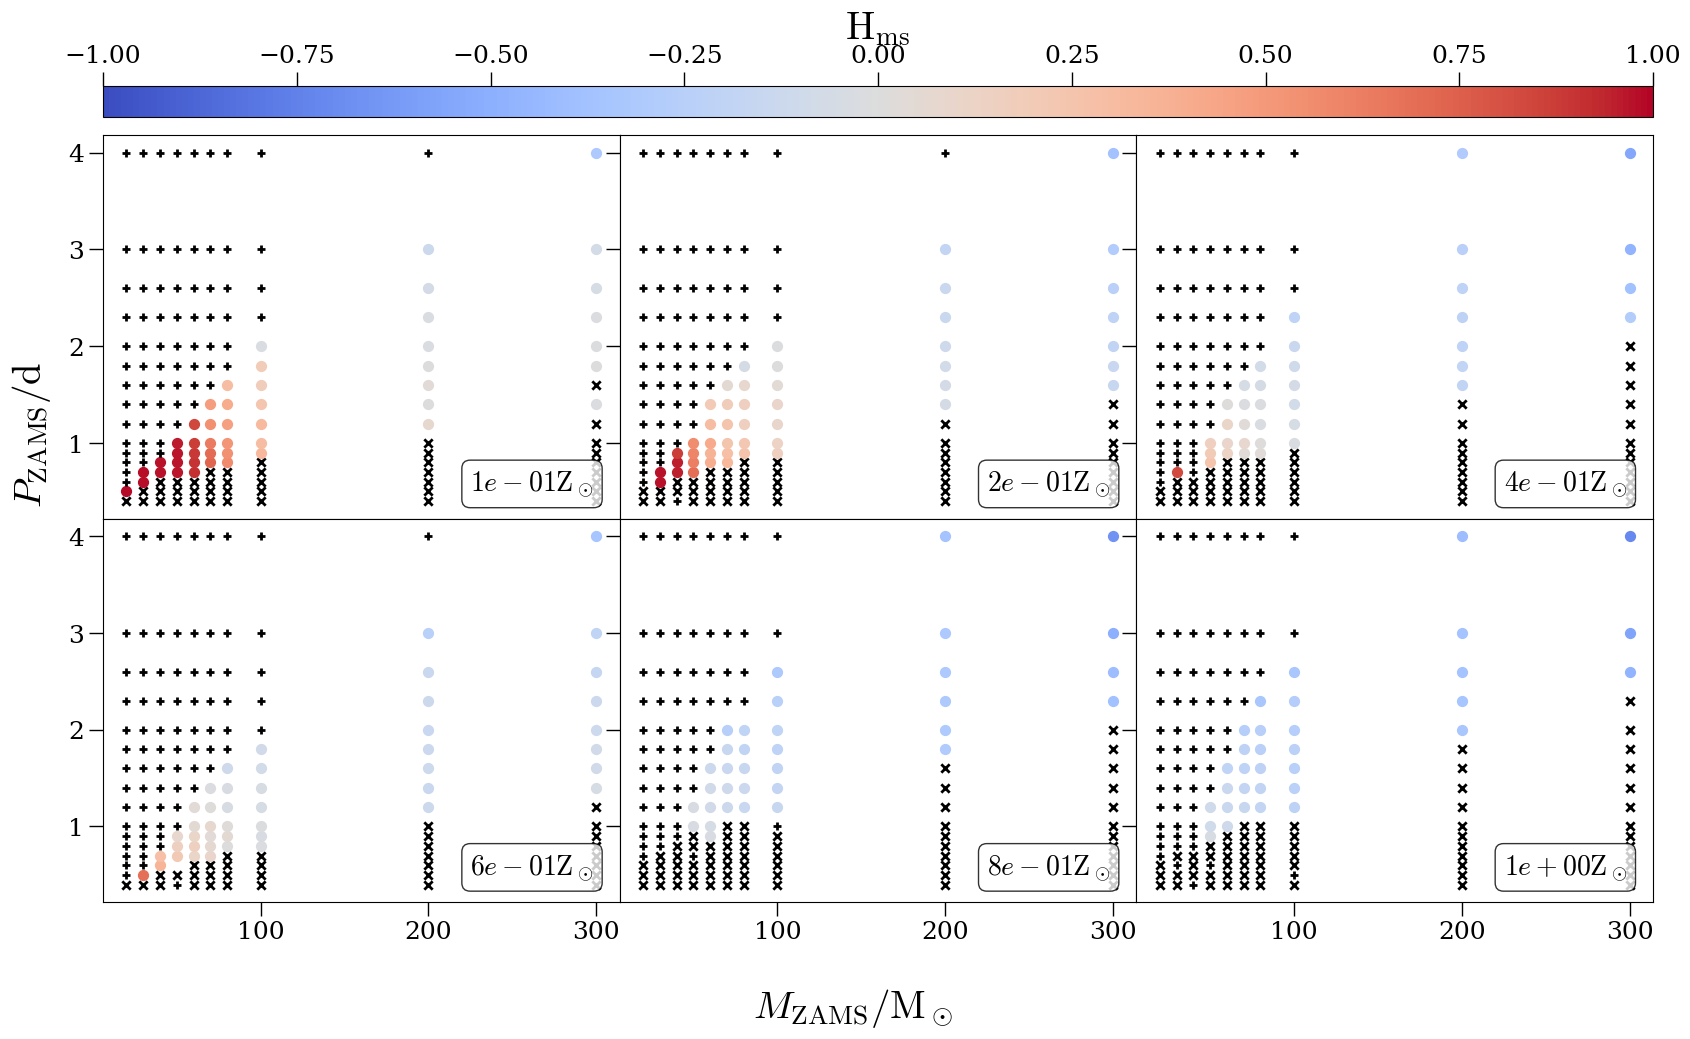

In [155]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
cmap = cm.coolwarm
cmin = -1
cmax = 1
size = 50

guide_z_str = list(final_core_prop_array_dict.keys())
labelbox_props = dict(boxstyle='round', facecolor='white', alpha=0.8)

for i, (z_div_zsun, ax) in enumerate(zip(guide_z_str, axes.flatten())):
    ax = ms_score_scatter(
        i=i,
        z_div_zsun=z_div_zsun,
        ax=ax,
        cmap=cmap,
        cmin=cmin,
        cmax=cmax,
        size=size
    )
    
    ax.text(0.95, 0.05, f'${float(z_div_zsun):.0e}\mathrm{{Z}}_\odot$', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=20, bbox=labelbox_props)
    
fig.text(0.1, 0.5, '$P_\mathrm{ZAMS}/\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.04, '$M_\mathrm{ZAMS}/\mathrm{M}_\odot$', ha='center', va='top', transform=fig.transFigure)

sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=cmin, vmax=cmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.02, aspect=50, location='top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$\mathrm{H}_\mathrm{ms}$')

savefig(fig, 'ms_score_panels')

In [156]:
def adjust_brightness(color, factor):
    """
    Adjust brightness of an RGBA color (4-tuple), preserving alpha.

    Parameters:
        color (tuple): RGBA tuple (R, G, B, A) from a colormap.
        factor (float): Brightness factor (>1 = brighter, <1 = darker)

    Returns:
        tuple: New RGBA color with adjusted brightness
    """
    r, g, b, a = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r_new, g_new, b_new = colorsys.hls_to_rgb(h, l, s)
    r_new = max(min(r_new, 1), 0)
    g_new = max(min(g_new, 1), 0)
    b_new = max(min(b_new, 1), 0)
    return (r_new, g_new, b_new, a)


In [157]:
def ms_score_pie_scatter(i, z_div_zsun, ax, cvar, cmap, cmin, cmax, darkening_factor=0.5, pie_size=50, highlight_mergers=False):
    guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(all_model_dicts[z_div_zsun])

    for j, m in enumerate(guide_m_float):
        m_key = guide_m_str[j]
        for k, p in enumerate(guide_p_float):
            core_props = final_core_prop_array_dict[z_div_zsun][k][j]
            core_props = np.core.records.fromarrays(
                core_props, 
                names=','.join(core_props_header),
                formats='f8,f8,f8,f8,f8,f8,f8,f8,i4,i4,f8,f8'
                )
            c_x = core_props[cvar]
            c = cmap(
                (c_x - cmin)/(cmax - cmin)
            )
            
            p_key = guide_p_str[k]
            ms_score = ms_score_matrix[i, j, k]
            
            if core_props.is_crit_at_zams:
                ax.scatter(m, p, c='gray', marker='x', alpha=0.5)
            elif not core_props.is_che:
                ax.scatter(m, p, c='gray', marker='+', alpha=0.5)
            else:        
                # Represent mixing-stripping as a pie chart where the dark fraction
                # corresponds to the fraction of enrichment due to mixing
                mix_f = (ms_score + 1) / 2
                if mix_f > 0.95:
                    mix_f = 1
                strip_f = 1 - mix_f
                        
                ## Build marker for the mixed slice
                x_m = [0] + np.cos(np.linspace(0, 2*np.pi * mix_f, 10)).tolist()
                y_m = [0] + np.sin(np.linspace(0, 2*np.pi * mix_f, 10)).tolist()
                xy_m = np.column_stack((x_m, y_m))
                c_m = adjust_brightness(c, darkening_factor)
                
                ## Build marker for the stripped slice
                x_s = [0] + np.cos(np.linspace(2*np.pi * mix_f, 2*np.pi, 10)).tolist()
                y_s = [0] + np.sin(np.linspace(2*np.pi * mix_f, 2*np.pi, 10)).tolist()
                xy_s = np.column_stack((x_s, y_s))
                c_s = c
                
                a = 1
                if highlight_mergers:
                    if (core_props.t_delay > th 
                        or core_props.is_crit_at_zams
                        or not core_props.is_che):
                        c = 'silver'
                        c_m = 'gray'
                        a = 0.5
            
                
                ax.scatter(m, p, marker=xy_m, s=pie_size, facecolor=c_m, alpha=a)
                if mix_f != 1:
                    ax.scatter(m, p, marker=xy_s, s=pie_size, facecolor=c_s, alpha=a)
                
    return ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


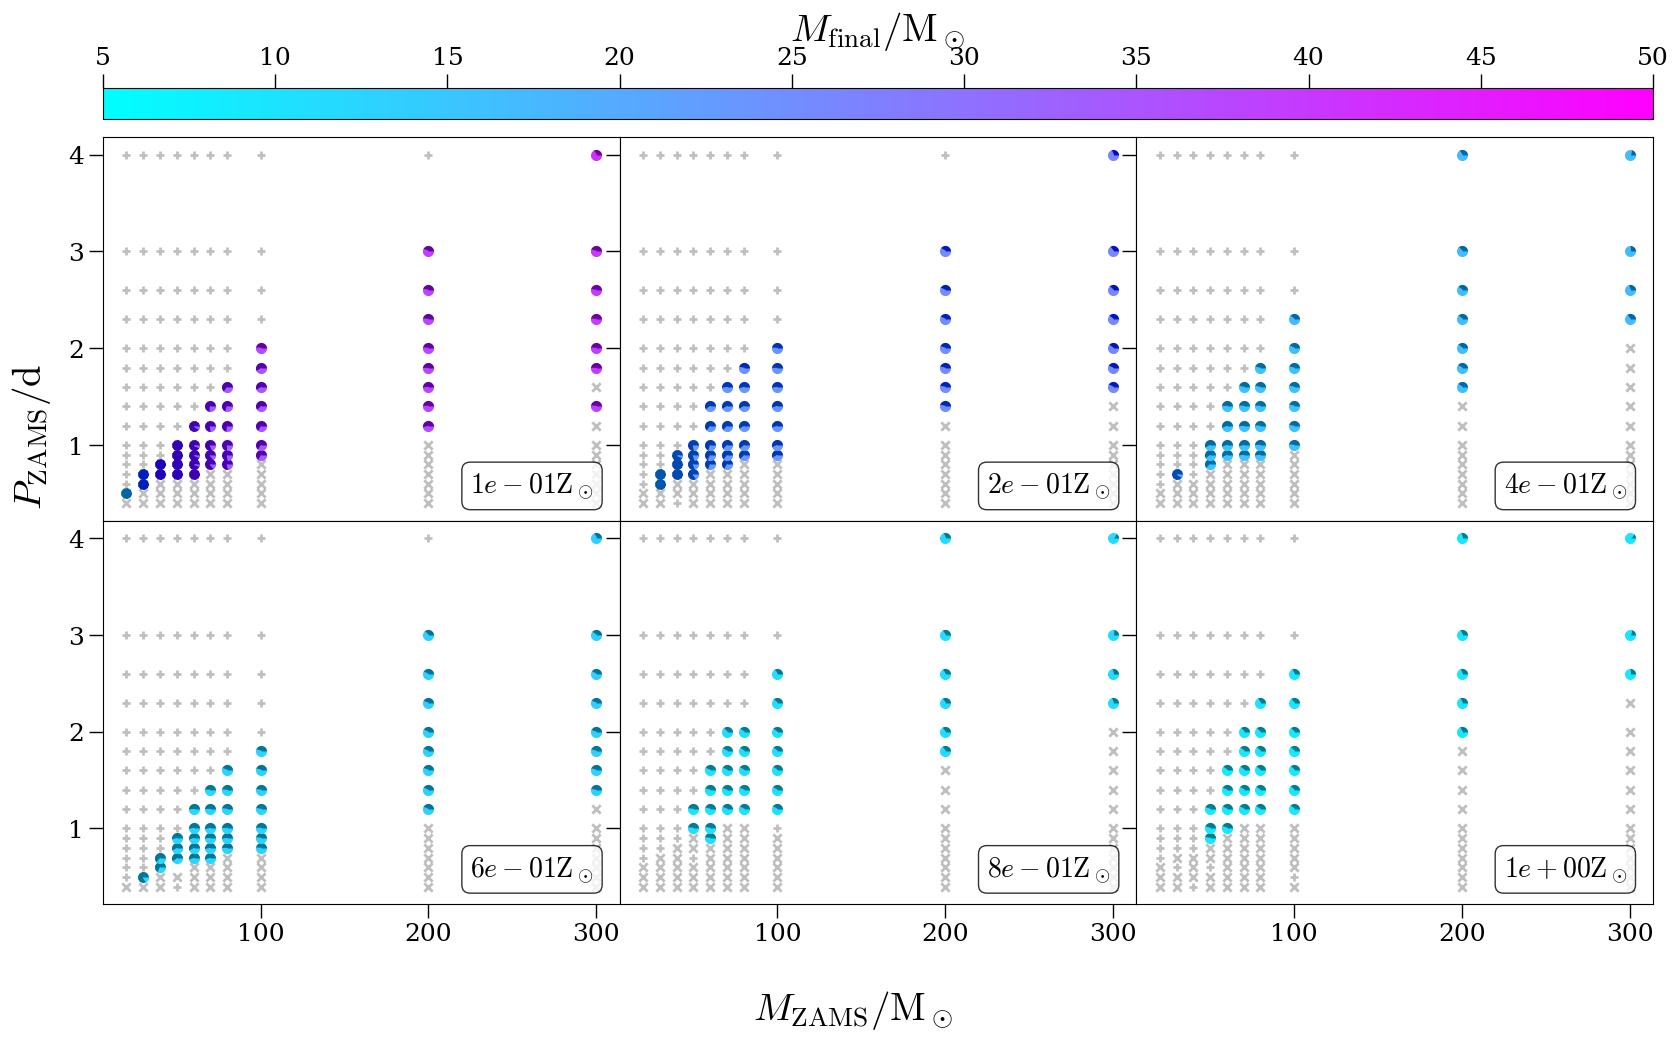

In [158]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
cvar = 'm_final'
cmap = cm.cool
cmin = 5
cmax = 50
darkening_factor = 0.5
pie_size = 50
highlight_mergers = False

guide_z_str = list(final_core_prop_array_dict.keys())
labelbox_props = dict(boxstyle='round', facecolor='white', alpha=0.8)

for i, (z_div_zsun, ax) in enumerate(zip(guide_z_str, axes.flatten())):
    ax = ms_score_pie_scatter(
        i=i,
        z_div_zsun=z_div_zsun,
        ax=ax,
        cvar=cvar,
        cmap=cmap,
        cmin=cmin,
        cmax=cmax,
        darkening_factor=darkening_factor,
        pie_size=pie_size,
        highlight_mergers=highlight_mergers
    )
    
    ax.text(0.95, 0.05, f'${float(z_div_zsun):.0e}\mathrm{{Z}}_\odot$', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=20, bbox=labelbox_props)
    
fig.text(0.1, 0.5, '$P_\mathrm{ZAMS}/\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.04, '$M_\mathrm{ZAMS}/\mathrm{M}_\odot$', ha='center', va='top', transform=fig.transFigure)

sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=cmin, vmax=cmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.02, aspect=50, location='top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$M_\mathrm{final}/\mathrm{M}_\odot$')

savefig(fig, 'ms_score_pie_mfinal_panels')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


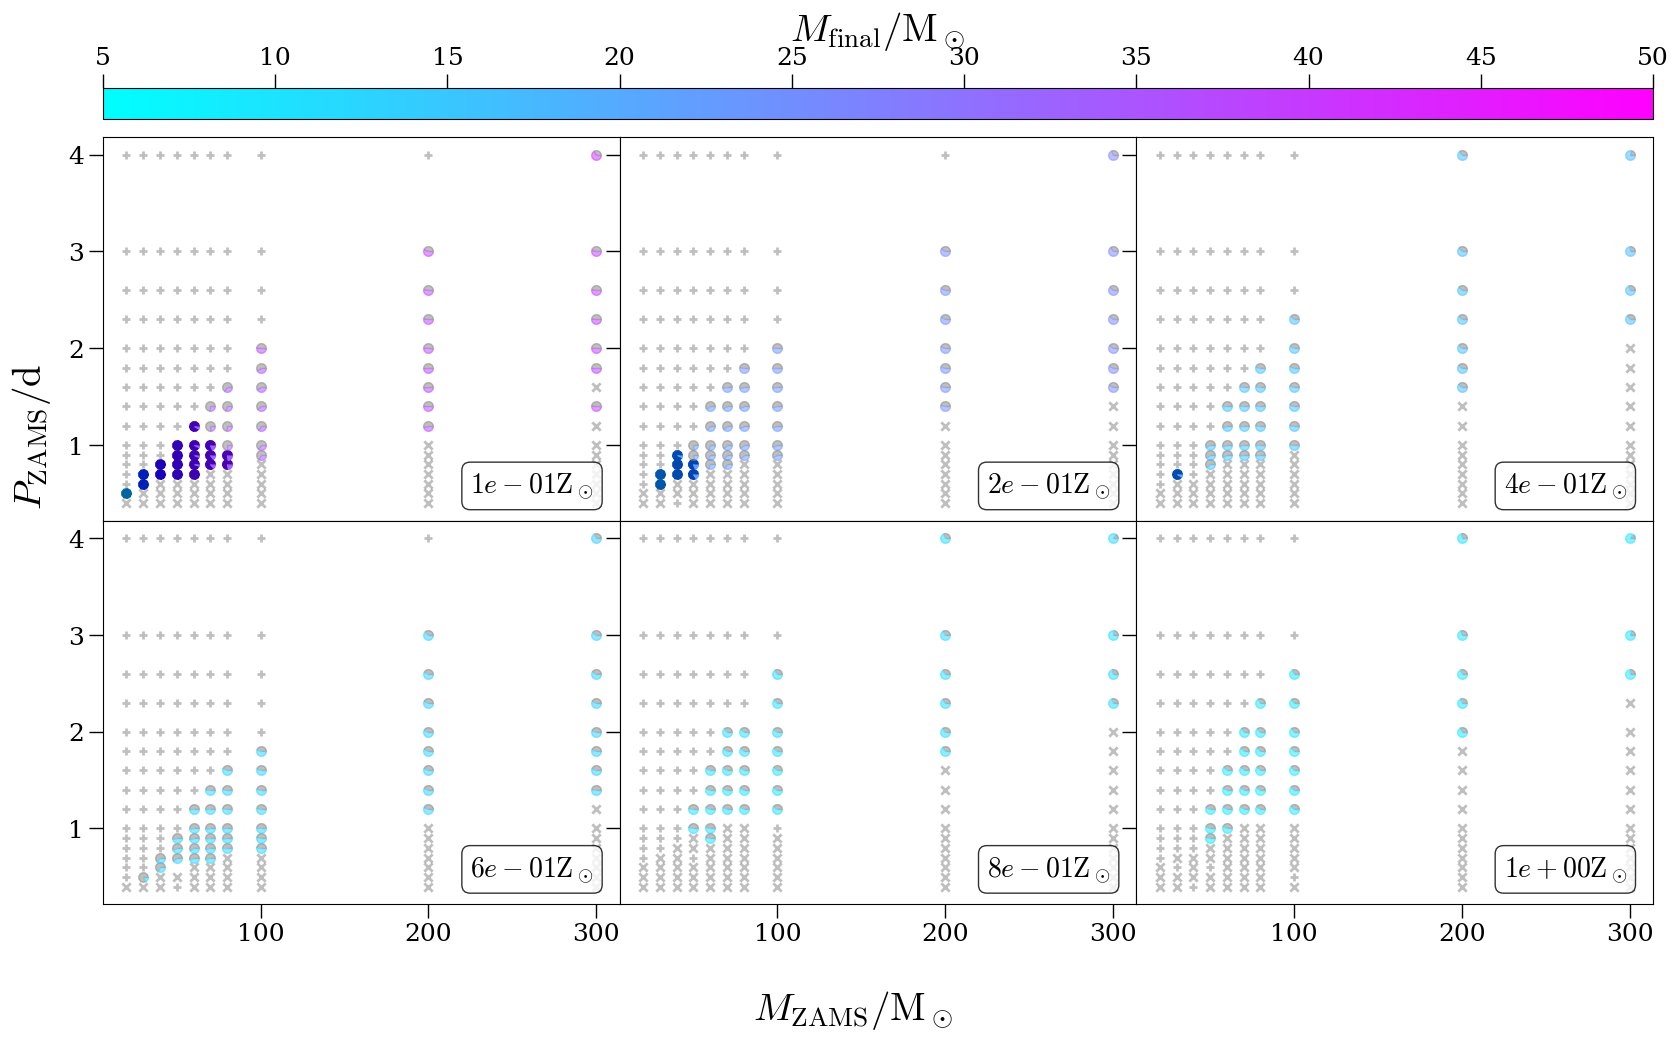

In [159]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
cvar = 'm_final'
cmap = cm.cool
cmin = 5
cmax = 50
darkening_factor = 0.5
pie_size = 50
highlight_mergers = True

guide_z_str = list(final_core_prop_array_dict.keys())
labelbox_props = dict(boxstyle='round', facecolor='white', alpha=0.8)

for i, (z_div_zsun, ax) in enumerate(zip(guide_z_str, axes.flatten())):
    ax = ms_score_pie_scatter(
        i=i,
        z_div_zsun=z_div_zsun,
        ax=ax,
        cvar=cvar,
        cmap=cmap,
        cmin=cmin,
        cmax=cmax,
        darkening_factor=darkening_factor,
        pie_size=pie_size,
        highlight_mergers=highlight_mergers
    )
    
    ax.text(0.95, 0.05, f'${float(z_div_zsun):.0e}\mathrm{{Z}}_\odot$', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=20, bbox=labelbox_props)
    
fig.text(0.1, 0.5, '$P_\mathrm{ZAMS}/\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.04, '$M_\mathrm{ZAMS}/\mathrm{M}_\odot$', ha='center', va='top', transform=fig.transFigure)

sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=cmin, vmax=cmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.02, aspect=50, location='top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$M_\mathrm{final}/\mathrm{M}_\odot$')

savefig(fig, 'ms_score_pie_mfinal_mergers_panels')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


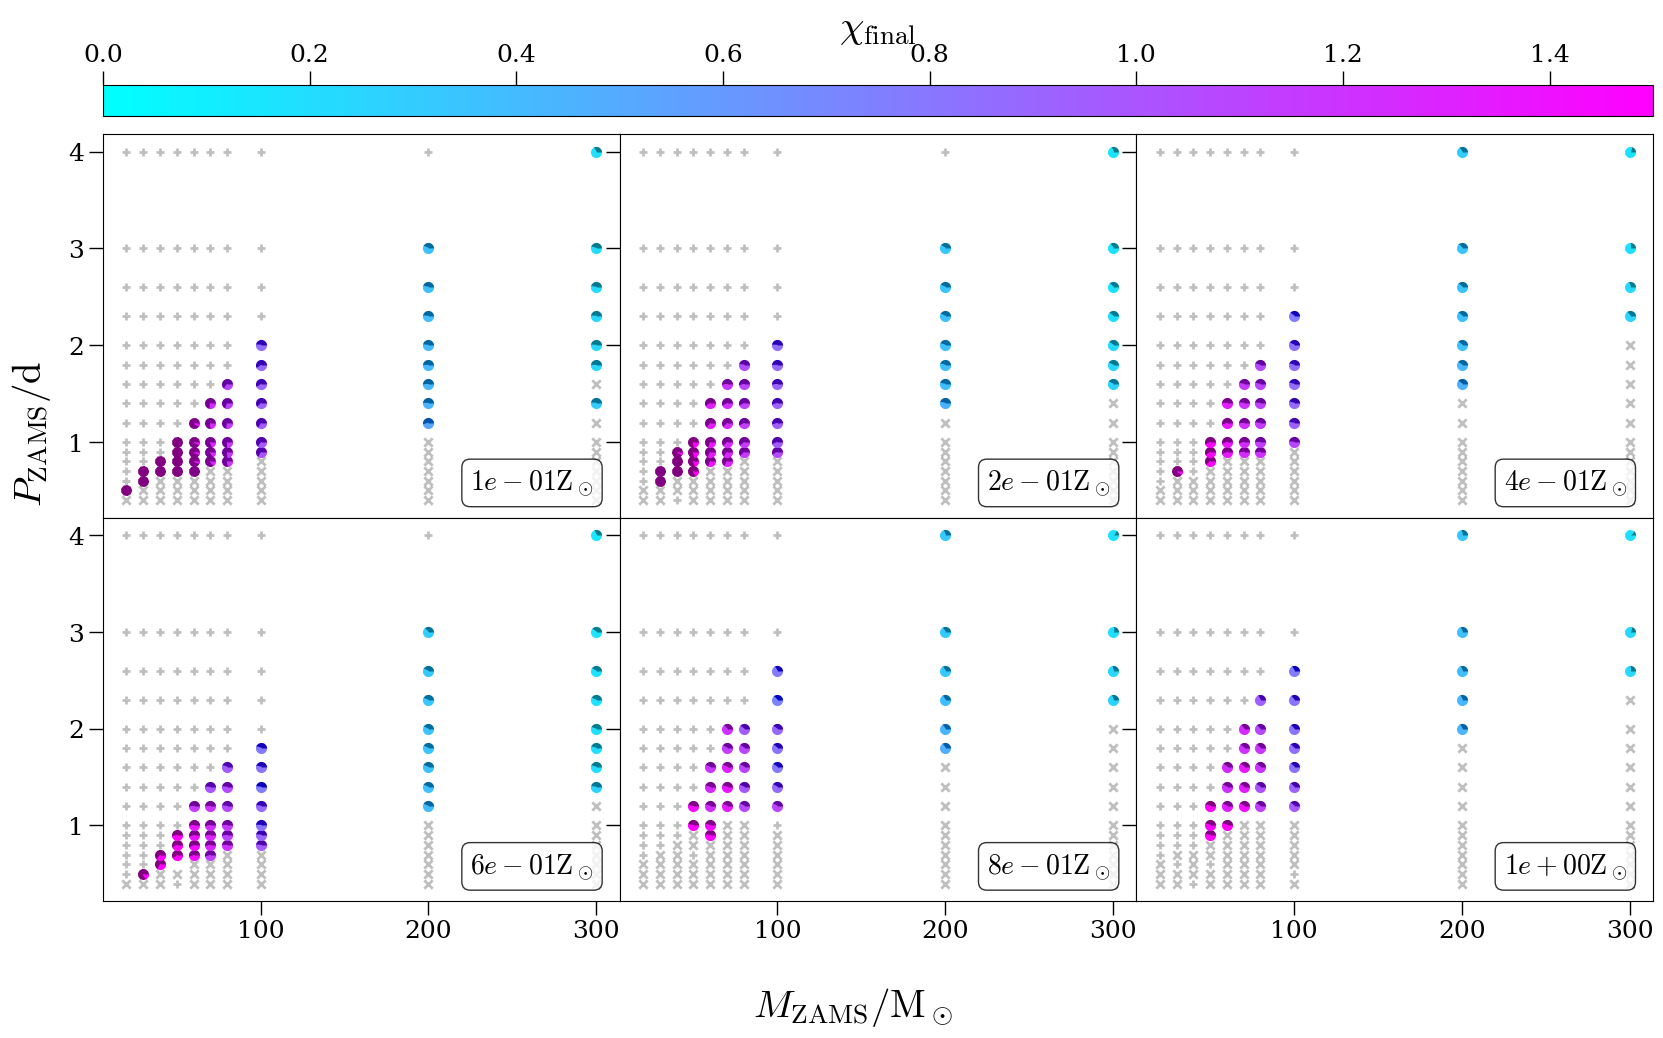

In [160]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
cvar = 'x_final'
cmap = cm.cool
cmin = 0
cmax = 1.5
darkening_factor = 0.5
pie_size = 50

guide_z_str = list(final_core_prop_array_dict.keys())
labelbox_props = dict(boxstyle='round', facecolor='white', alpha=0.8)

for i, (z_div_zsun, ax) in enumerate(zip(guide_z_str, axes.flatten())):
    ax = ms_score_pie_scatter(
        i=i,
        z_div_zsun=z_div_zsun,
        ax=ax,
        cvar=cvar,
        cmap=cmap,
        cmin=cmin,
        cmax=cmax,
        darkening_factor=darkening_factor,
        pie_size=pie_size
    )
    
    ax.text(0.95, 0.05, f'${float(z_div_zsun):.0e}\mathrm{{Z}}_\odot$', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=20, bbox=labelbox_props)
    
fig.text(0.1, 0.5, '$P_\mathrm{ZAMS}/\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.04, '$M_\mathrm{ZAMS}/\mathrm{M}_\odot$', ha='center', va='top', transform=fig.transFigure)

sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=cmin, vmax=cmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.02, aspect=50, location='top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$\chi_\mathrm{final}$')

savefig(fig, 'ms_score_pie_xfinal_panels')

## Projected rotation velocity X Nitrogen abundance

In [ ]:
np.random.rand()

In [171]:
guide_z_str = list(final_core_prop_array_dict.keys())
guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(all_model_dicts[z_div_zsun])

age_v_sini_nh_arr = []

def build_z_nh_matrix(z_div_zsun):
    v_sini_nh_list = []
    for j, m in enumerate(guide_m_float):
        m_key = guide_m_str[j]
        for k, p in enumerate(guide_p_float):
            p_key = guide_p_str[k]
            path = all_model_dicts[z_div_zsun][m_key][p_key]
            try:
                h = mr.MesaData(str(path/'LOGS/history.data'))
                tams_i = np.where(h.center_h1 <= 1e-6)[0][0]
            except:
                continue
            nh_arr = h.surface_n14[:tams_i]/h.surface_h1[:tams_i]
            vrot_arr = h.surf_avg_v_rot[:tams_i]
            sini_arr = np.sin(np.random.uniform(0, 2*np.pi, len(nh_arr)))
            v_sini_nh = np.array([vrot_arr, sini_arr, nh_arr]).T
            v_sini_nh_list.append(v_sini_nh)
    return v_sini_nh_list
                                 
with ProcessPoolExecutor(max_workers=16) as executor:
    v_sini_nh_lists = list(executor.map(build_z_nh_matrix, guide_z_str))

In [ ]:
v_sini_nh_arr = []
for i in range(len(v_sini_nh_lists)):
    arr = np.concatenate(v_sini_nh_lists[i])
    v_sini_nh_arr.append(arr)
    
v_sini_nh_arr = np.concatenate(v_sini_nh_arr)

In [179]:
np.save(DATA_ROOT/'v_sini_nh_arr.npy', v_sini_nh_arr)

(array([[3.0950e+03, 5.3000e+01, 7.0000e+01, 2.3300e+02, 1.8850e+03,
         2.2140e+04, 1.6902e+04, 7.2880e+03, 2.5000e+03, 1.1660e+03],
        [2.5100e+02, 4.5000e+01, 9.1000e+01, 2.1100e+02, 1.9960e+03,
         5.1060e+03, 9.2600e+02, 5.2000e+02, 1.0200e+02, 8.0000e+00],
        [2.7800e+02, 6.2000e+01, 9.5000e+01, 2.3800e+02, 2.0670e+03,
         2.3130e+03, 5.5500e+02, 1.3800e+02, 1.4100e+02, 1.9000e+01],
        [3.2500e+02, 7.9000e+01, 1.6200e+02, 3.4500e+02, 1.8490e+03,
         1.2470e+03, 3.1700e+02, 1.1500e+02, 7.6000e+01, 1.4000e+01],
        [3.4400e+02, 7.3000e+01, 8.9000e+01, 2.7900e+02, 1.5220e+03,
         8.1600e+02, 1.4600e+02, 1.7000e+01, 5.0000e+01, 0.0000e+00],
        [2.4400e+02, 4.7000e+01, 8.5000e+01, 2.2600e+02, 1.1200e+03,
         4.1200e+02, 0.0000e+00, 0.0000e+00, 2.0000e+01, 0.0000e+00],
        [2.1700e+02, 4.0000e+01, 5.2000e+01, 1.4700e+02, 7.3500e+02,
         7.6000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00],
        [7.9000e+01, 1.4000

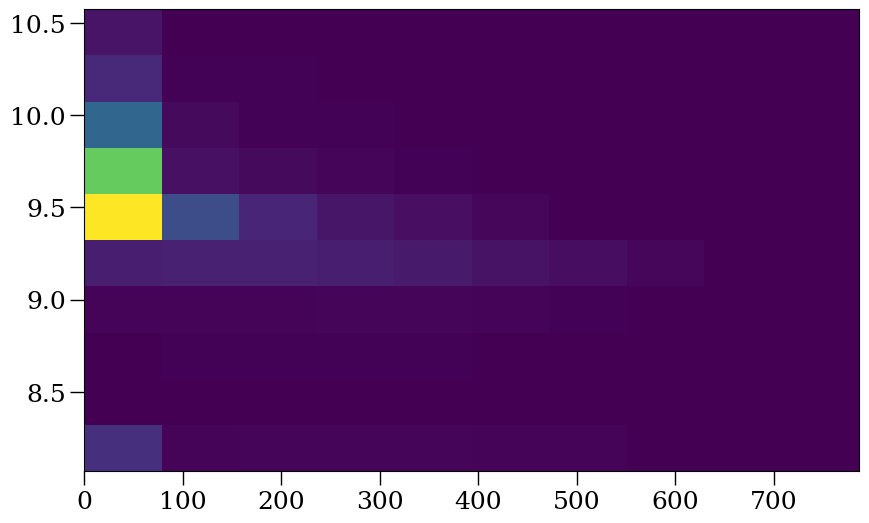

In [194]:
fig, ax = plt.subplots(figsize=(10,6))

data = v_sini_nh_arr#[12+np.log10(v_sini_nh_arr[:, 2]) < 8]
x = np.abs(data[:, 0] * data[:, 1])
y = 12 + np.log10(data[:, 2])

ax.hist2d(x, y)